DNN but with the 50:50 ratio between SM e BSM enforced with weights

In [1]:
from glob import glob
import sys, scipy, pickle
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.10/08


/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [3]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, ModelCheckpoint
from keras.constraints import max_norm
from keras.models import load_model
import keras
print keras.__version__

2.1.2


In [4]:
do_training = 1

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark', 'hToTauTau', 'hChToTauNu']

N_train_max = int(6e6)
training_split_fraction = 0.5

In [7]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
#     np.random.shuffle(raw_sample[n])
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
N_train = min(N_train_max, training_split_fraction*l[i_min]/fraction[i_min])
if N_train < N_train_max:
    print 'Limiting stat. sample:', TrainSamplesName[i_min]
else:
    print 'Sample available satisfying '

N_val = N_train*(1-training_split_fraction)/training_split_fraction - 1
print 'Expected {:.2f} train'.format(N_train/1.0e6)
print 'Expected {:.2f} val'.format(N_val/1.0e6)

x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    N_val_aux = int(N_val * fraction[i])
    if N_train_aux+N_val_aux < raw_sample[n].shape[0]:
        x_val_s[n] = raw_sample[n][N_train_aux : N_train_aux+N_val_aux, sel]
    else:
        print 'Error', n
        continue
    table.add_row([n, raw_sample[n].shape[0], x_train_s[n].shape[0], x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

print 'Tot training {:.2f} M'.format(x_train.shape[0]/1.0e6)
print 'Tot val {:.2f} M'.format(x_val.shape[0]/1.0e6)

Limiting stat. sample: qcd
Expected 3.01 train
Expected 3.01 val
+--------+----------+---------+---------+
| Sample | Evts tot |  Train  |   Val   |
+--------+----------+---------+---------+
|  Wlnu  | 8000082  | 1781124 | 1781124 |
|  qcd   | 2033852  | 1016926 | 1016925 |
|  Zll   | 1777383  |  201580 |  201579 |
| ttbar  | 5001726  |   9025  |   9025  |
+--------+----------+---------+---------+
Tot training 3.01 M
Tot val 3.01 M


In [8]:
x_sig = {}
weight_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
#     np.random.shuffle(s)
    x_sig[n] = s[:int(N_train_max/training_split_fraction), sel]
    w = float(x_train.shape[0])/(training_split_fraction*x_sig[n].shape[0])
    weight_sig[n] = w
    print '{} {:.3f}M ({:.1f})'.format(n, s.shape[0]*1.e-6, w)

Ato4l 0.343M (17.6)
Zprime 0.055M (108.7)
Wprime 0.606M (9.9)
leptoquark 0.274M (22.0)
hToTauTau 0.345M (17.4)
hChToTauNu 0.339M (17.7)


# Start the Classifier declaration

In [9]:
original_dim = x_train.shape[1]
act_fun = 'relu'
clf = {}

In [10]:
global w_BSM
w_BSM = 1.0

def weighted_binary_xentropy(y_true, y_pred):
    print w_BSM
    aux = K.binary_crossentropy(y_true, y_pred)

    w = K.tf.where(K.tf.greater(y_true, 0.5), K.tf.ones_like(y_true)*w_BSM, K.tf.ones_like(y_true))
    return K.dot(K.transpose(w), aux)/K.sum(w)

In [11]:
def plot_history(h, tag='', save_values=False):
    f = plt.figure(figsize=(16,8))
    plt.plot(h['loss'][1:], '.-', label='loss')
    plt.plot(h['val_loss'][1:], '.--', label='val_loss')

    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc='best')
    plt.yscale('log')
    if tag:
        f.savefig('Classifier_HLF_v3/{}_training_hisotry.png'.format(tag))
        if save_values:
            f = open('Classifier_HLF_v3/{}_training_hisotry.pkl'.format(tag), 'w')
            pickle.dump(h, f, pickle.HIGHEST_PROTOCOL)
            f.close()

In [12]:
def train_it(model, n, ES_p=30, RLRP_p=10, epochs=100):
    clf[n] = model

    global w_BSM
    w_BSM = weight_sig[n]
    clf[n].compile(loss=weighted_binary_xentropy, optimizer='adam')
#     clf[n].compile(loss='binary_crossentropy', optimizer='adam')

    print '\n\n------------------ Training', n, '--------------------'
    l_bsm = int(x_sig[n].shape[0]*training_split_fraction)
    aux_x = np.concatenate(( x_train, x_sig[n][:l_bsm] ))
    aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(l_bsm) ))
    aux_xval = np.concatenate(( x_val, x_sig[n][l_bsm:] ))
    aux_yval = np.concatenate(( np.zeros(x_val.shape[0]), np.ones(x_sig[n].shape[0] - l_bsm) ))

    clf[n].report = clf[n].fit(x=aux_x, y=aux_y, batch_size=500, epochs=epochs,
                          shuffle=True,
                          validation_data= (aux_xval, aux_yval),
                          callbacks = [
                                        EarlyStopping(monitor='val_loss', patience=ES_p, verbose=1),
                                        ReduceLROnPlateau(monitor='val_loss', patience=RLRP_p, verbose=1),
                                        TerminateOnNaN(),
                                        ModelCheckpoint('Classifier_HLF_v3/Clf_{}_best.hdf5'.format(n), 
                                                    monitor='val_loss',
                                                    save_best_only=True, 
                                                    save_weights_only=True)
                                      ]
                         )
    plot_history(clf[n].report.history, n, True)

### Do the training

17.5651983536


------------------ Training Ato4l --------------------
Train on 3179940 samples, validate on 3179938 samples
Epoch 1/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 1.6486 - val_loss: 0.1790
Epoch 2/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 0.2024 - val_loss: 0.1709
Epoch 3/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 0.1918 - val_loss: 0.1534
Epoch 4/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 0.1853 - val_loss: 0.1856
Epoch 5/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 0.1804 - val_loss: 0.1704
Epoch 6/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 0.1766 - val_loss: 0.1581
Epoch 7/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 0.1742 - val_loss: 0.1329
Epoch 8/100
3179940/3179940 [==============================] - 13s 4us/step - loss: 0.1716 - val_loss: 0.

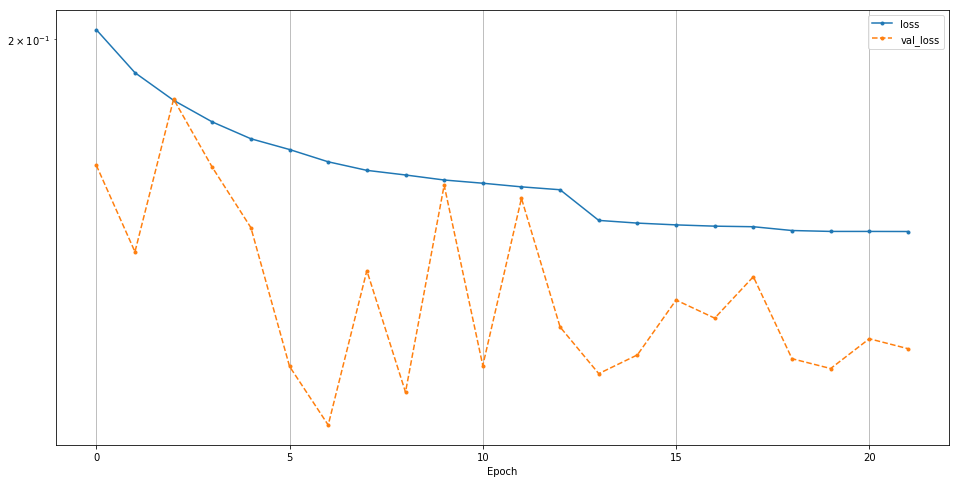

2018-11-06 17:25:07.514875: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [13]:
n = 'Ato4l'

if do_training:
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(20, activation=act_fun, name='h1_'+n)(inputs)
    #     mdl = Dropout(0.2)(mdl)
    mdl = Dense(20, activation=act_fun, name='h2_'+n)(mdl)
#     mdl = Dropout(0.1)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    train_it(Model(inputs=inputs, outputs=mdl), n)
else:
    clf[n] = load_model('Classifier_HLF_v3/Classifier_'+n+'_v3.h5')

108.690256855


------------------ Training Zprime --------------------
Train on 3036336 samples, validate on 3036334 samples
Epoch 1/100
3036336/3036336 [==============================] - 19s 6us/step - loss: 0.3893 - val_loss: 0.1988
Epoch 2/100
3036336/3036336 [==============================] - 19s 6us/step - loss: 0.2968 - val_loss: 0.1533
Epoch 3/100
3036336/3036336 [==============================] - 19s 6us/step - loss: 0.2745 - val_loss: 0.2432
Epoch 4/100
3036336/3036336 [==============================] - 19s 6us/step - loss: 0.2614 - val_loss: 0.2104
Epoch 5/100
3036336/3036336 [==============================] - 19s 6us/step - loss: 0.2584 - val_loss: 0.2662
Epoch 6/100
3036336/3036336 [==============================] - 19s 6us/step - loss: 0.2574 - val_loss: 0.2462
Epoch 7/100
3036336/3036336 [==============================] - 19s 6us/step - loss: 0.2564 - val_loss: 0.2073
Epoch 8/100
3036336/3036336 [==============================] - 20s 7us/step - loss: 0.2550 - val_loss: 0

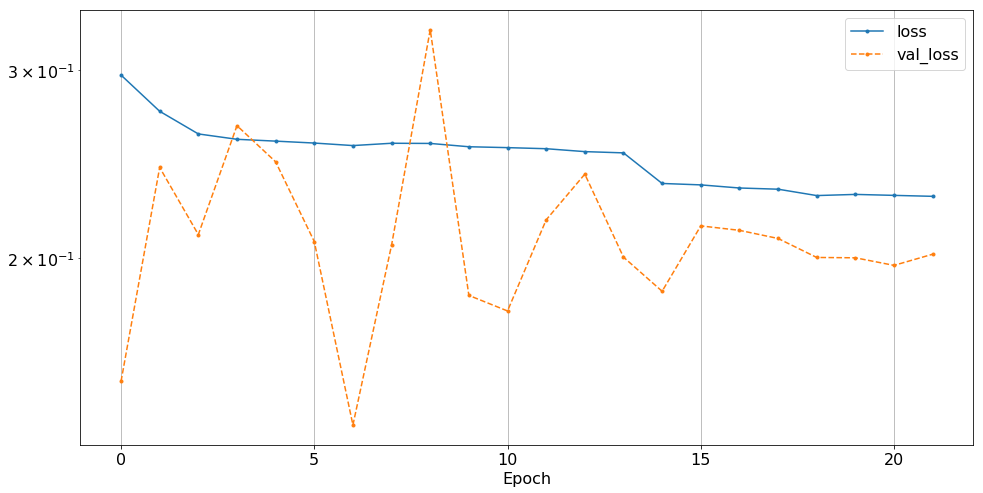

In [26]:
n = 'Zprime'
if do_training:
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(50, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
#     mdl = Dropout(0.4)(mdl)
    mdl = Dense(50, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
#     mdl = Dropout(0.4)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    train_it(Model(inputs=inputs, outputs=mdl), n)
else:
    clf[n] = load_model('Classifier_'+n+'_v1.h5')

9.93509581252


------------------ Training Wprime --------------------
Train on 3311486 samples, validate on 3311484 samples
Epoch 1/100
3311486/3311486 [==============================] - 22s 7us/step - loss: 0.5973 - val_loss: 0.5915
Epoch 2/100
3311486/3311486 [==============================] - 21s 6us/step - loss: 0.5589 - val_loss: 0.6220
Epoch 3/100
3311486/3311486 [==============================] - 20s 6us/step - loss: 0.5541 - val_loss: 0.5805
Epoch 4/100
3311486/3311486 [==============================] - 21s 6us/step - loss: 0.5511 - val_loss: 0.5945
Epoch 5/100
3311486/3311486 [==============================] - 21s 6us/step - loss: 0.5494 - val_loss: 0.5186
Epoch 6/100
3311486/3311486 [==============================] - 21s 6us/step - loss: 0.5482 - val_loss: 0.5365
Epoch 7/100
3311486/3311486 [==============================] - 21s 6us/step - loss: 0.5480 - val_loss: 0.5702
Epoch 8/100
3311486/3311486 [==============================] - 21s 6us/step - loss: 0.5473 - val_loss: 0

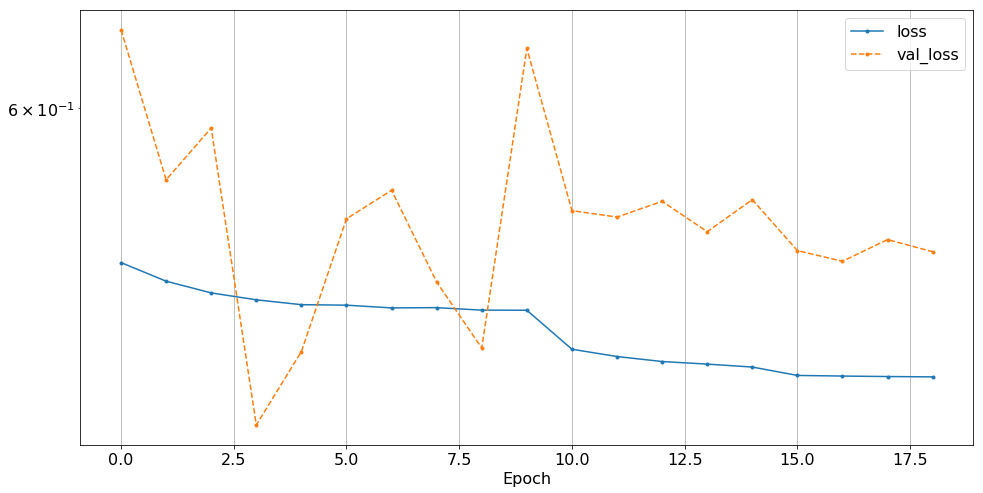

In [27]:
n = 'Wprime'
if do_training:
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(50, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
#     mdl = Dropout(0.4)(mdl)
    mdl = Dense(50, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
#     mdl = Dropout(0.5)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    train_it(Model(inputs=inputs, outputs=mdl), n)
else:
    clf[n]= load_model('Classifier_'+n+'_v1.h5')

21.9927705735


------------------ Training leptoquark --------------------
Train on 3145457 samples, validate on 3145455 samples
Epoch 1/100
3145457/3145457 [==============================] - 15s 5us/step - loss: 0.8126 - val_loss: 0.4658
Epoch 2/100
3145457/3145457 [==============================] - 15s 5us/step - loss: 0.3913 - val_loss: 0.4216
Epoch 3/100
3145457/3145457 [==============================] - 15s 5us/step - loss: 0.3617 - val_loss: 0.2103
Epoch 4/100
3145457/3145457 [==============================] - 15s 5us/step - loss: 0.3582 - val_loss: 0.2921
Epoch 5/100
3145457/3145457 [==============================] - 15s 5us/step - loss: 0.3557 - val_loss: 0.2633
Epoch 6/100
3145457/3145457 [==============================] - 15s 5us/step - loss: 0.3549 - val_loss: 0.2914
Epoch 7/100
3145457/3145457 [==============================] - 14s 5us/step - loss: 0.3573 - val_loss: 0.3563
Epoch 8/100
3145457/3145457 [==============================] - 15s 5us/step - loss: 0.3524 - val_los

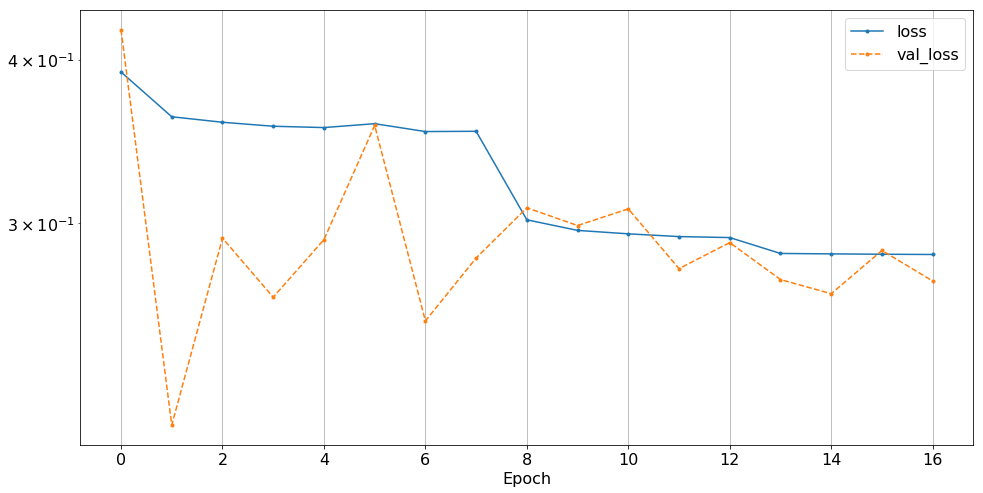

In [17]:
n = 'leptoquark'
if do_training:
    intermediate_dim = 40
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
#     mdl = Dropout(0.3)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
#     mdl = Dropout(0.4)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    train_it(Model(inputs=inputs, outputs=mdl), n)
else:
    clf[n] = load_model('Classifier_'+n+'_v1.h5')

17.4456753364


------------------ Training hToTauTau --------------------
Train on 3181113 samples, validate on 3181112 samples
Epoch 1/100
3181113/3181113 [==============================] - 15s 5us/step - loss: 0.5500 - val_loss: 0.6026
Epoch 2/100
3181113/3181113 [==============================] - 15s 5us/step - loss: 0.4605 - val_loss: 0.2983
Epoch 3/100
3181113/3181113 [==============================] - 15s 5us/step - loss: 0.4411 - val_loss: 0.4432
Epoch 4/100
3181113/3181113 [==============================] - 15s 5us/step - loss: 0.4343 - val_loss: 0.3329
Epoch 5/100
3181113/3181113 [==============================] - 15s 5us/step - loss: 0.4328 - val_loss: 0.4239
Epoch 6/100
3181113/3181113 [==============================] - 15s 5us/step - loss: 0.4304 - val_loss: 0.4002
Epoch 7/100
3181113/3181113 [==============================] - 15s 5us/step - loss: 0.4326 - val_loss: 0.4463
Epoch 8/100
3176000/3181113 [============================>.] - ETA: 0s - loss: 0.4292- ETA: 0
Epoch 0

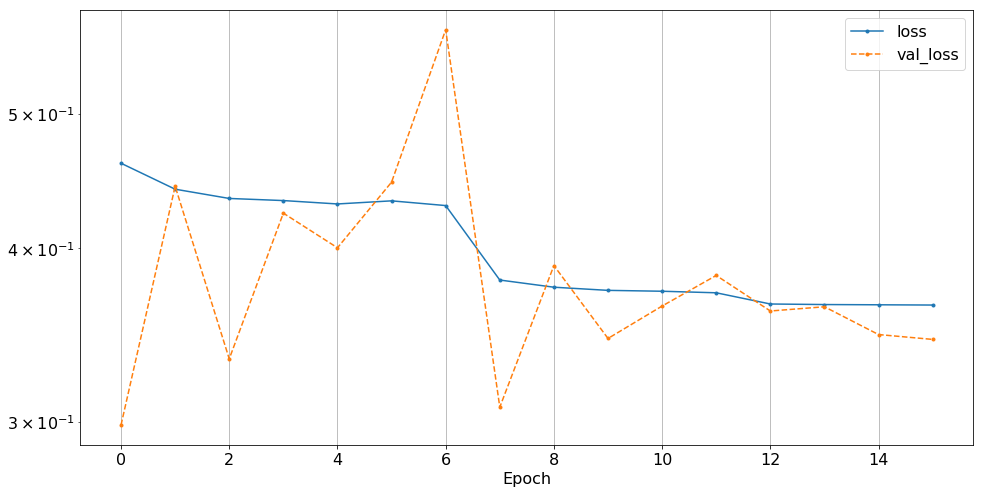

In [18]:
n = 'hToTauTau'
if do_training:
    intermediate_dim = 40
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
#     mdl = Dropout(0.3)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
#     mdl = Dropout(0.4)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    train_it(Model(inputs=inputs, outputs=mdl), n)
else:
    clf[n] = load_model('Classifier_'+n+'_v1.h5')

17.7492345539


------------------ Training hChToTauNu --------------------
Train on 3178164 samples, validate on 3178162 samples
Epoch 1/100
3178164/3178164 [==============================] - 19s 6us/step - loss: 0.4481 - val_loss: 0.3013
Epoch 2/100
3178164/3178164 [==============================] - 19s 6us/step - loss: 0.3355 - val_loss: 0.2225
Epoch 3/100
3178164/3178164 [==============================] - 18s 6us/step - loss: 0.3196 - val_loss: 0.4567
Epoch 4/100
3178164/3178164 [==============================] - 18s 6us/step - loss: 0.3091 - val_loss: 0.3118
Epoch 5/100
3178164/3178164 [==============================] - 18s 6us/step - loss: 0.3069 - val_loss: 0.3735
Epoch 6/100
3178164/3178164 [==============================] - 18s 6us/step - loss: 0.3086 - val_loss: 0.3712
Epoch 7/100
3178164/3178164 [==============================] - 15s 5us/step - loss: 0.3099 - val_loss: 0.1892
Epoch 8/100
3178164/3178164 [==============================] - 15s 5us/step - loss: 0.3078 - val_los

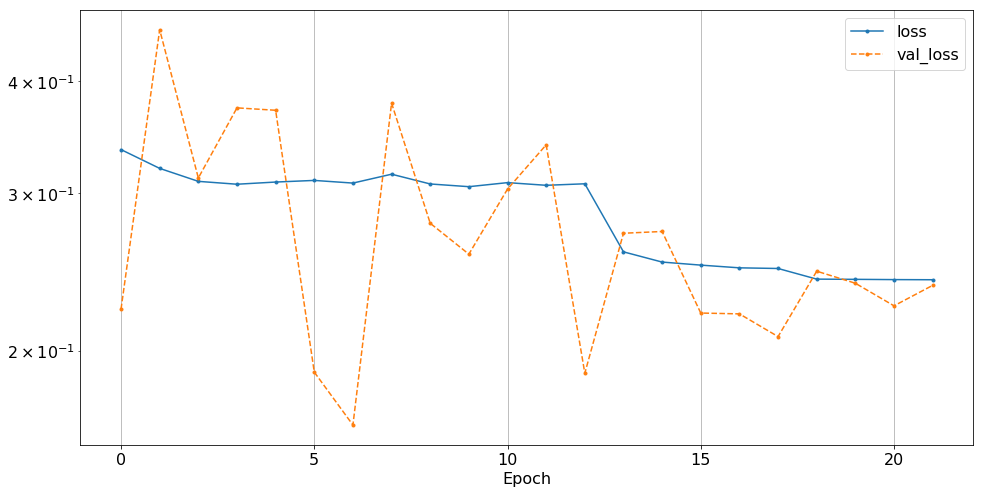

In [19]:
n = 'hChToTauNu'
if do_training:
    intermediate_dim = 40
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
#     mdl = Dropout(0.3)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
#     mdl = Dropout(0.4)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    train_it(Model(inputs=inputs, outputs=mdl), n)
else:
    clf[n] = load_model('Classifier_'+n+'_v1.h5')

## Plot the ROC curves

In [20]:
Eff_SM = 5.38e-06

In [21]:
def ROC_curve(p_BSM, p_SM, eval_q_SM):
    eval_p = np.percentile(1-p_SM, q=100*eval_q_SM)
    
    out = (1-p_BSM) < eval_p
    out = np.sum(out, axis=0)
    q_BSM = out/float(p_BSM.shape[0])
    
    AUC = np.trapz(q_BSM, eval_q_SM)
    
    return q_BSM, AUC

hToTauTau: 2.38e-04
hChToTauNu: 1.88e-03
Wprime: 3.30e-06
Ato4l: 1.61e-01
leptoquark: 7.31e-05
Zprime: 5.42e-03


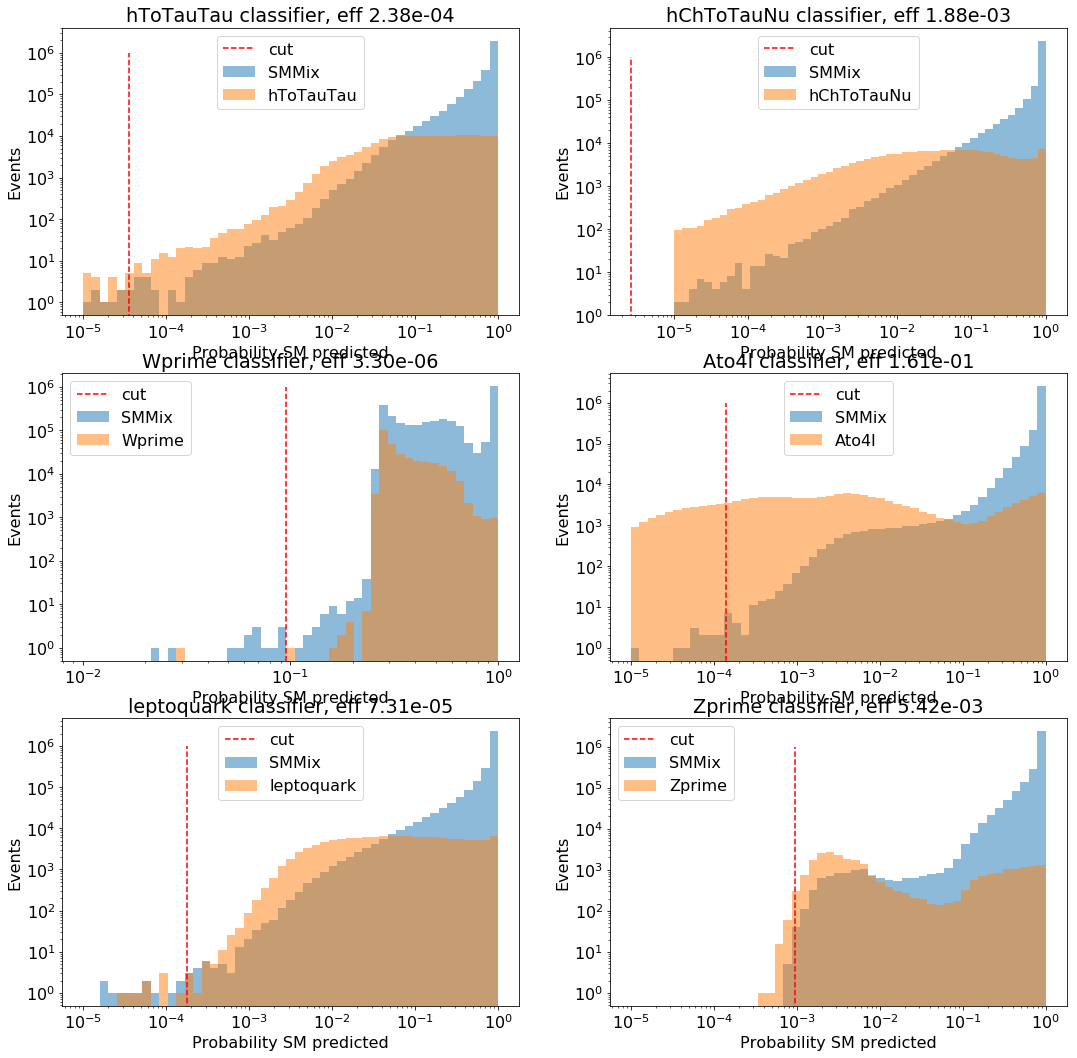

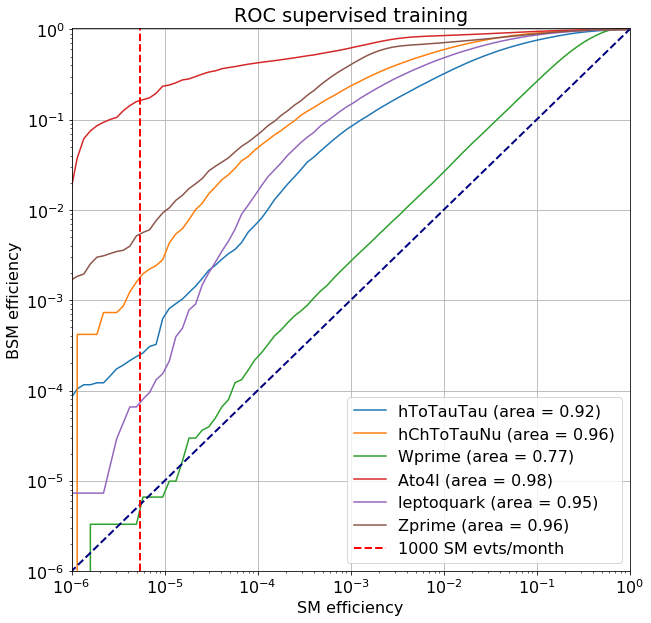

In [28]:
matplotlib.rcParams.update({'font.size': 16})

f, ax_arr = plt.subplots(3,2 , figsize=(18,18))

f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))

for i,n in enumerate(clf.keys()):
    p_SM = clf[n].predict(x_val, batch_size=2000)
    
    l_bsm = int(x_sig[n].shape[0]*training_split_fraction)
    p_BSM = clf[n].predict(x_sig[n][l_bsm:], batch_size=2000)
    
    # print ROC curve
    q_SM = np.logspace(base=10, start=-7, stop=0, num=100)
    q_BSM, roc_auc = ROC_curve(p_BSM, p_SM, q_SM)
    dic2save = {'eff_BSM':q_BSM, 'eff_SM':q_SM, 'roc_auc':roc_auc}
    fileout = open('Classifier_HLF_v3/ROC_dict_{}.pkl'.format(n), 'w')
    pickle.dump(file=fileout, obj=dic2save)
    fileout.close()
    ax_arr_ROC.plot(q_SM, q_BSM, label='{} (area = {:0.2f})'.format(n, roc_auc))
    
    

    q = np.percentile(p_SM, 100*(1-Eff_SM))
    eff_BSM = float(np.sum(p_BSM>q))/x_sig[n][l_bsm:].shape[0]

    print '{}: {:1.2e}'.format(n, eff_BSM)
    
    bins = np.logspace(base=10, start=-5, stop=0, num=50)
    if n=='Wprime':
        bins = np.logspace(base=10, start=-2, stop=0, num=50)
    ax_arr[i/2,i%2].hist(1-p_SM, bins=bins, alpha = 0.5, label='SMMix')
    ax_arr[i/2,i%2].hist(1-p_BSM, bins=bins, alpha=0.5, label=n)
    ax_arr[i/2,i%2].plot([1-q,1-q], [0,1e6], '--r', label='cut')

    ax_arr[i/2,i%2].set_title('{} classifier, eff {:1.2e}'.format(n, eff_BSM))
    ax_arr[i/2,i%2].legend(loc='best')
    ax_arr[i/2,i%2].set_ylabel('Events')
    ax_arr[i/2,i%2].set_xlabel('Probability SM predicted')
    ax_arr[i/2,i%2].set_yscale('log')
    ax_arr[i/2,i%2].set_xscale('log')
    
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax_arr_ROC.plot([Eff_SM, Eff_SM], [1e-6, 1.05], color='red', lw=2, linestyle='--', label='1000 SM evts/month')
ax_arr_ROC.set_xlim([1e-6, 1.0])
ax_arr_ROC.set_ylim([1e-6, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency')
ax_arr_ROC.set_ylabel('BSM efficiency')
ax_arr_ROC.set_title('ROC supervised training')
ax_arr_ROC.legend(loc="lower right")
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.grid()
f_ROC.savefig('Classifier_HLF_v3/ROC_clf.png')

In [29]:
for k,c in clf.iteritems():
    c.save('Classifier_HLF_v3/Classifier_'+k+'_v3.h5')